In [25]:
#Importa as bibliotecas essenciais
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import tifffile
import skimage as ski
import cv2
from skimage.filters import threshold_multiotsu
from skimage import data, io
from skimage import exposure # Módulo onde o CLAHE está

In [31]:
file_path = '/home/ronald/Schistossoma/original_data/120dias/'

archives_names = [f for f in os.listdir(file_path)
                     if os.path.isfile(os.path.join(file_path, f))
                     and 'shg' in f.lower()
                     and f.lower().endswith('.tif')]                               #Arquivos ".tif" no diretório

path_destiny = '/home/ronald/Schistossoma/processed_files'

os.makedirs(path_destiny, exist_ok=True)

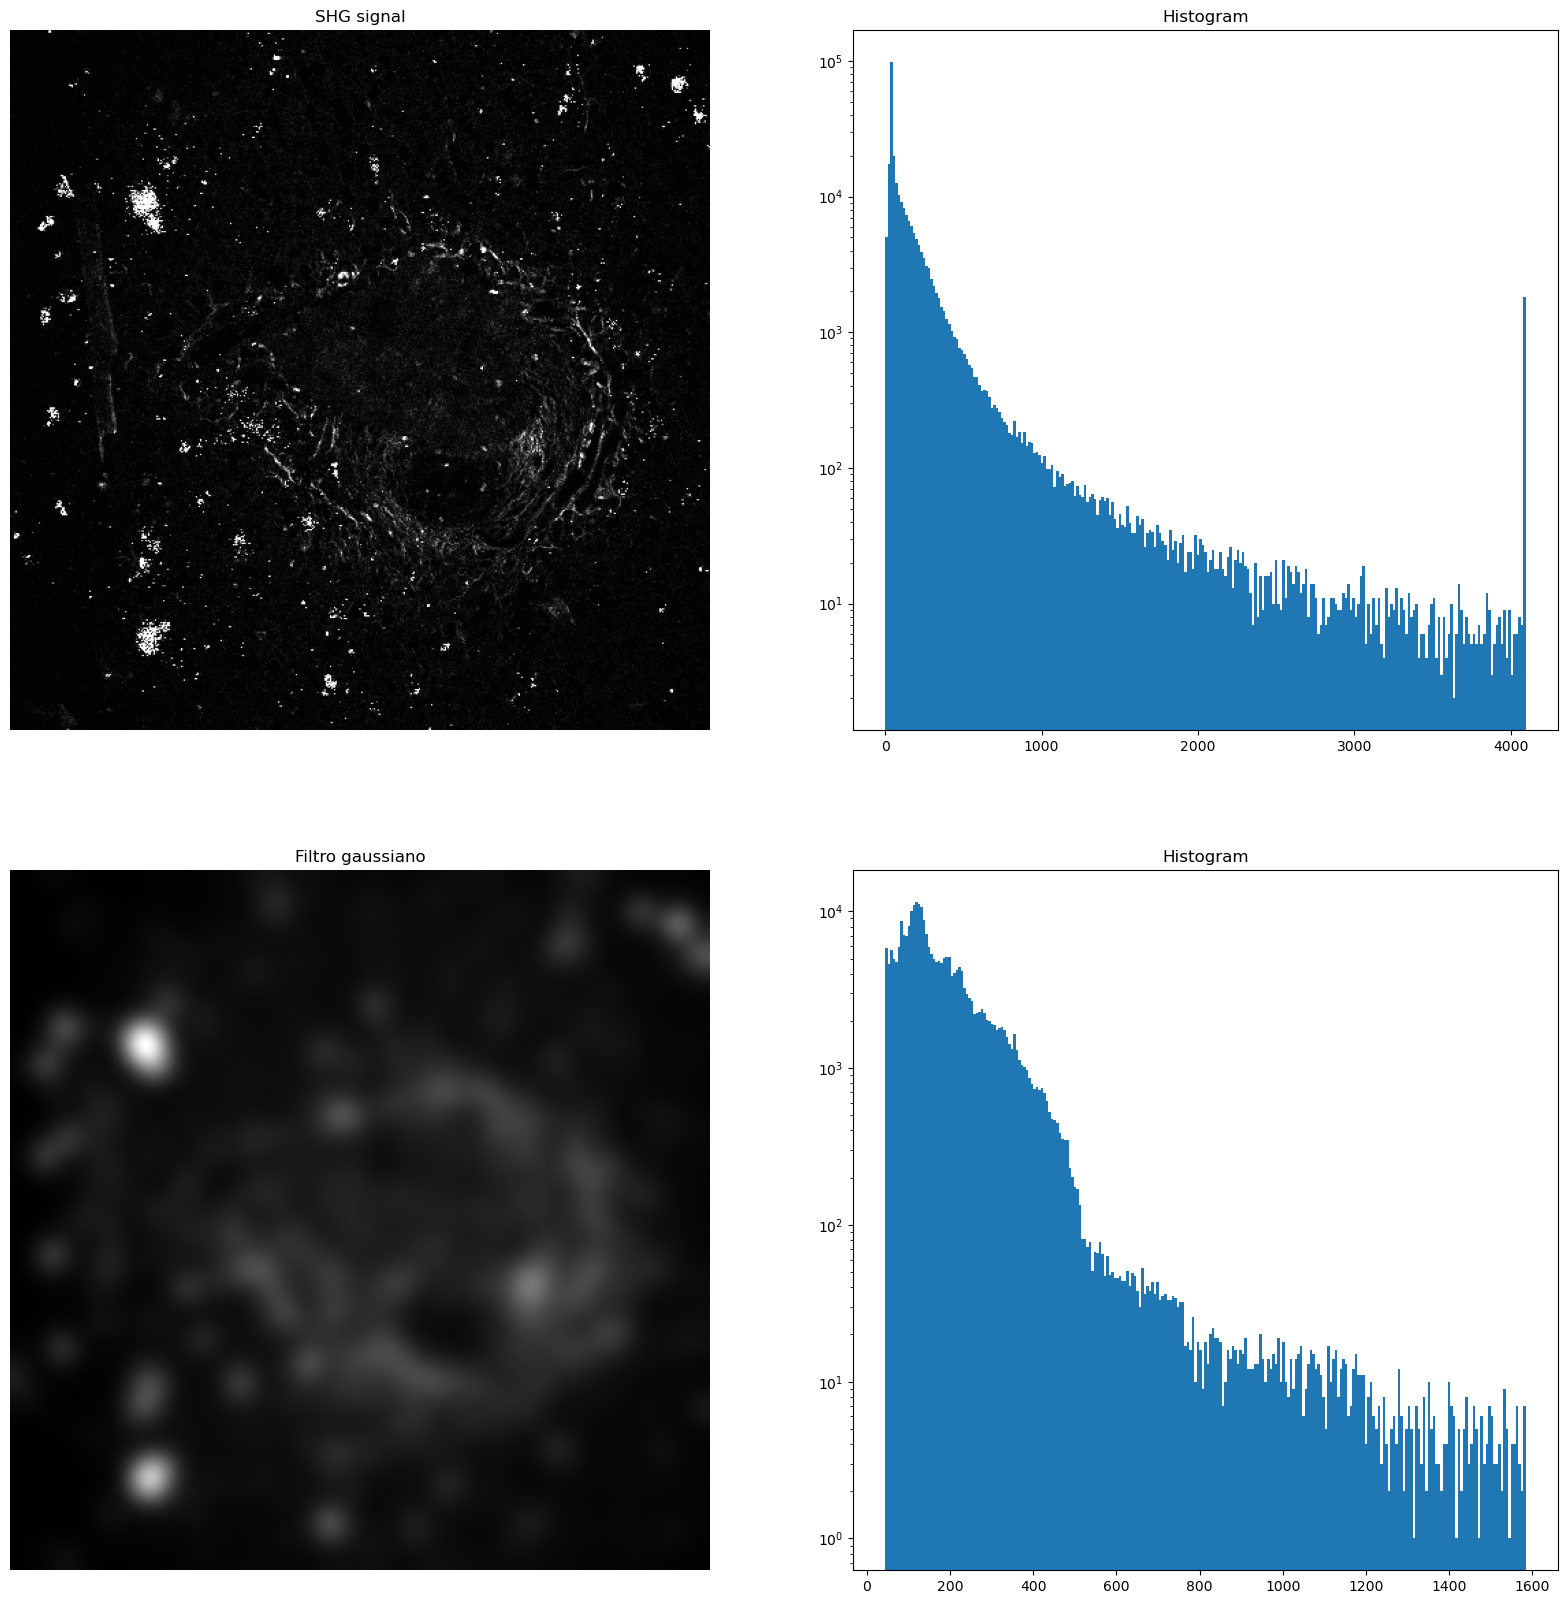

In [6]:
#Carrega a imagem
image = ski.io.imread(os.path.join(file_path, figure_name))[:,:,1]

# Filtro gaussiano grande -> só passa fundo lento
blur = cv2.GaussianBlur(image, (65,65), 0)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

ax[0,0].imshow(image, cmap='gray')
ax[0,0].set_title('SHG signal')
ax[0,0].axis('off')

ax[0,1].hist(image.ravel(),bins=255)
ax[0,1].set_title('Histogram')
ax[0,1].set_yscale('log')

ax[1,0].imshow(blur, cmap='gray')
ax[1,0].set_title('Filtro gaussiano')
ax[1,0].axis('off')


ax[1,1].hist(blur.ravel(),bins=255)
ax[1,1].set_title('Histogram')
ax[1,1].set_yscale('log')


plt.subplots_adjust()
plt.show()

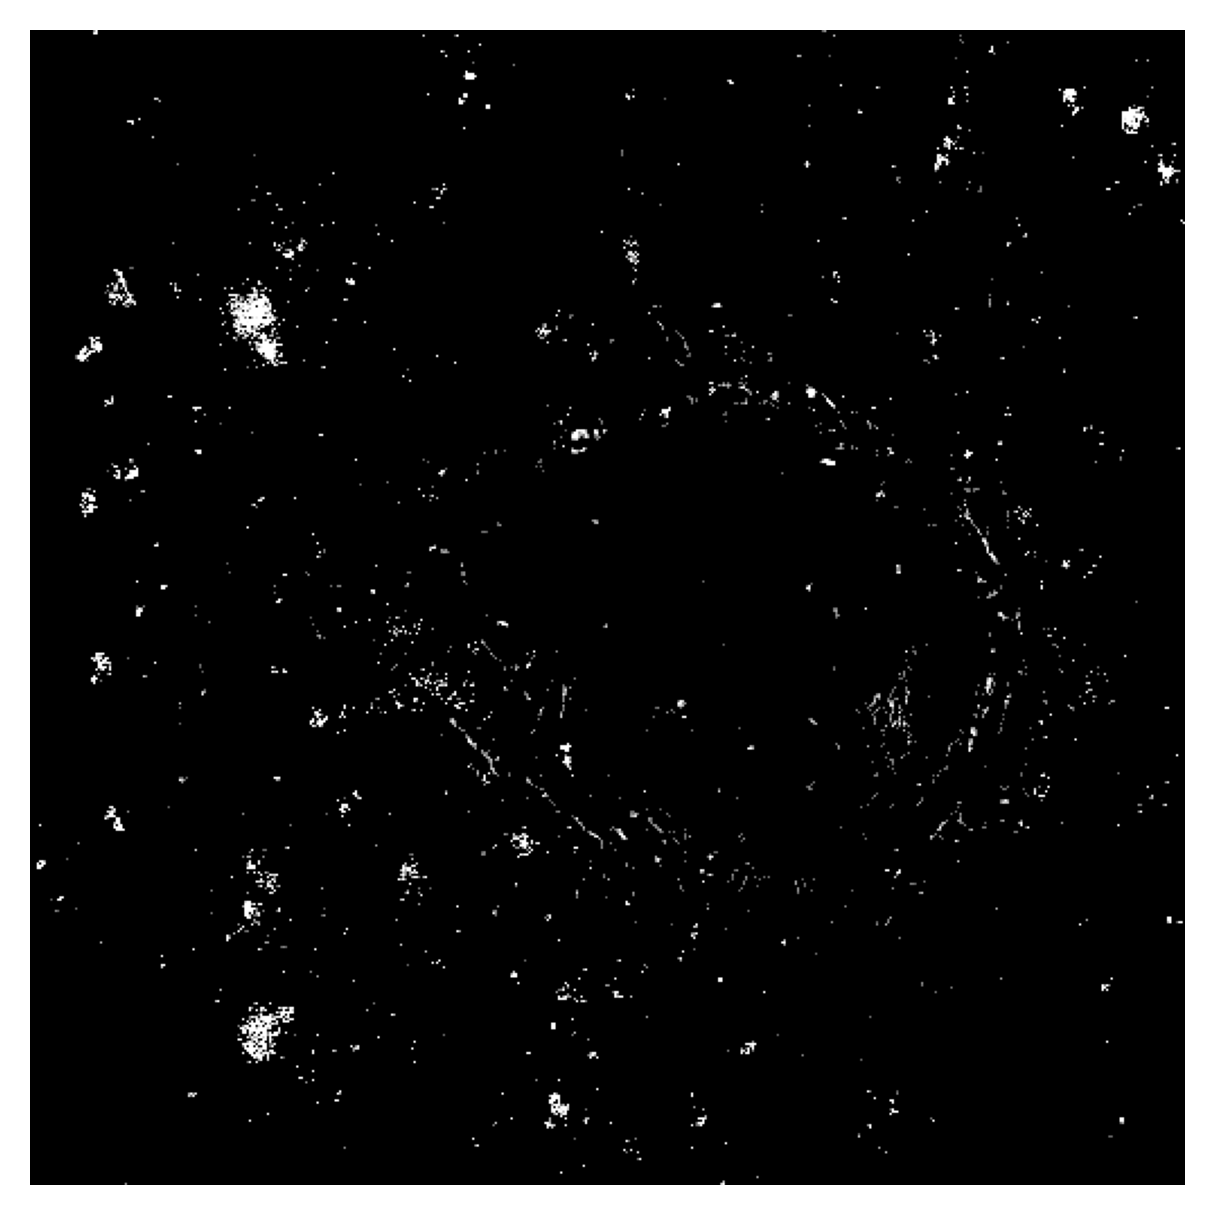

In [16]:
#Usando valor máximo de intensidade do passa baixa como threshold
copy_image = image.copy()
max_intensity = max(blur.ravel())
for row in copy_image:
  for i in range(len(row)):
    if row[i] <= max_intensity:
      row[i] = 0
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=300)
ax.imshow(copy_image, cmap='gray')
#ax.hist(copy_image.ravel(), bins=255)
#ax.set_yscale('log')
ax.axis('off')
plt.show()

In [18]:
def rescale(data, min_value, max_value):
  try:
    data_min, data_max = data.min(), data.max()
    data_scaled = np.round((data - data_min) * (max_value - min_value) / (data_max - data_min) + min_value)
    data_scaled[data_scaled > max_value] = max_value          #Garante que após o arredondamento nenhum valor seja superior ao valor máximo definido
    return data_scaled.astype(np.uint16)
  except Exception as e:
    print('Ocorreu um erro inesperado: {}'.format(e))
    return None

def calculate_treshold_and_variance_between_classes(image):
  '''Calcula o threshold que maximiza a variância entre classes (método de Otsu),
     assim como a variância máxima, para duas classes somente'''
  intensity, count = np.unique(image, return_counts=True)

  #intensity, count = intensity[1:-1], count[1:-1]
  
  n = len(intensity)

  probability = count/count.sum()

  cumulative_probability = probability.cumsum()

  E_i = intensity * probability

  partial_weighted_sum = E_i.cumsum()

  global_mean = E_i.sum()

  mean_C1 = np.zeros_like(intensity, dtype=float)

  cumulative_probability_C1 = np.zeros_like(intensity, dtype=float)

  mean_C0 = partial_weighted_sum/cumulative_probability

  mean_C1[:-1] = (partial_weighted_sum[-1] - partial_weighted_sum[:-1]) / (1 - cumulative_probability[:-1])

  cumulative_probability_C1[:-1] = 1 - cumulative_probability[:-1]

  variance_between_classes = cumulative_probability*(global_mean - mean_C0)**2+cumulative_probability_C1*(global_mean-mean_C1)**2

  indice_maior_valor = np.argmax(variance_between_classes)

  return intensity[indice_maior_valor], variance_between_classes[indice_maior_valor]


def find_best_parameters(image):
  clip_limits_to_try = np.arange(0.01,0.31,0.01)
  kernel_sizes_to_try = [(8,8),(12,12),(16,16),(20,20),(24,24),(28,28),(32,32),(36,36),(40,40),(44,44),(48,48),(52,52),(56,56),(60,60),(64,64)]
  clip_limits_index, kernel_sizes_index = np.meshgrid(np.arange(len(clip_limits_to_try)), np.arange(len(kernel_sizes_to_try)))
  clip_limits_index, kernel_sizes_index = clip_limits_index.flatten(), kernel_sizes_index.flatten()
  clip_limits = clip_limits_to_try[clip_limits_index]
  kernel_sizes = [kernel_sizes_to_try[i] for i in kernel_sizes_index]
  results = [
    calculate_treshold_and_variance_between_classes(
        rescale(exposure.equalize_adapthist(image, clip_limit=clip_limits[i], kernel_size=kernel_sizes[i]), min(image.ravel()), max(image.ravel()))
    )
    for i in range(len(clip_limits))
  ]
  thresholds, variances = zip(*results)
  return int(thresholds[np.argmax(variances)]), kernel_sizes[np.argmax(variances)], clip_limits[np.argmax(variances)]
def interest_class(figure):
  parameters = find_best_parameters(figure)
  threshold = parameters[0]
  SHG_class = figure.copy()
  for row in SHG_class:
    for i in range(len(row)):
      if row[i] < threshold:
        row[i] = 0
  return SHG_class, parameters

SHG_class, parameters = interest_class(blur)

In [ ]:
print(parameters)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=300)
#ax.imshow(SHG_class, cmap='gray')
ax.hist(SHG_class.ravel(), bins=255)
ax.set_yscale('log')
#ax.axis('off')
plt.show()

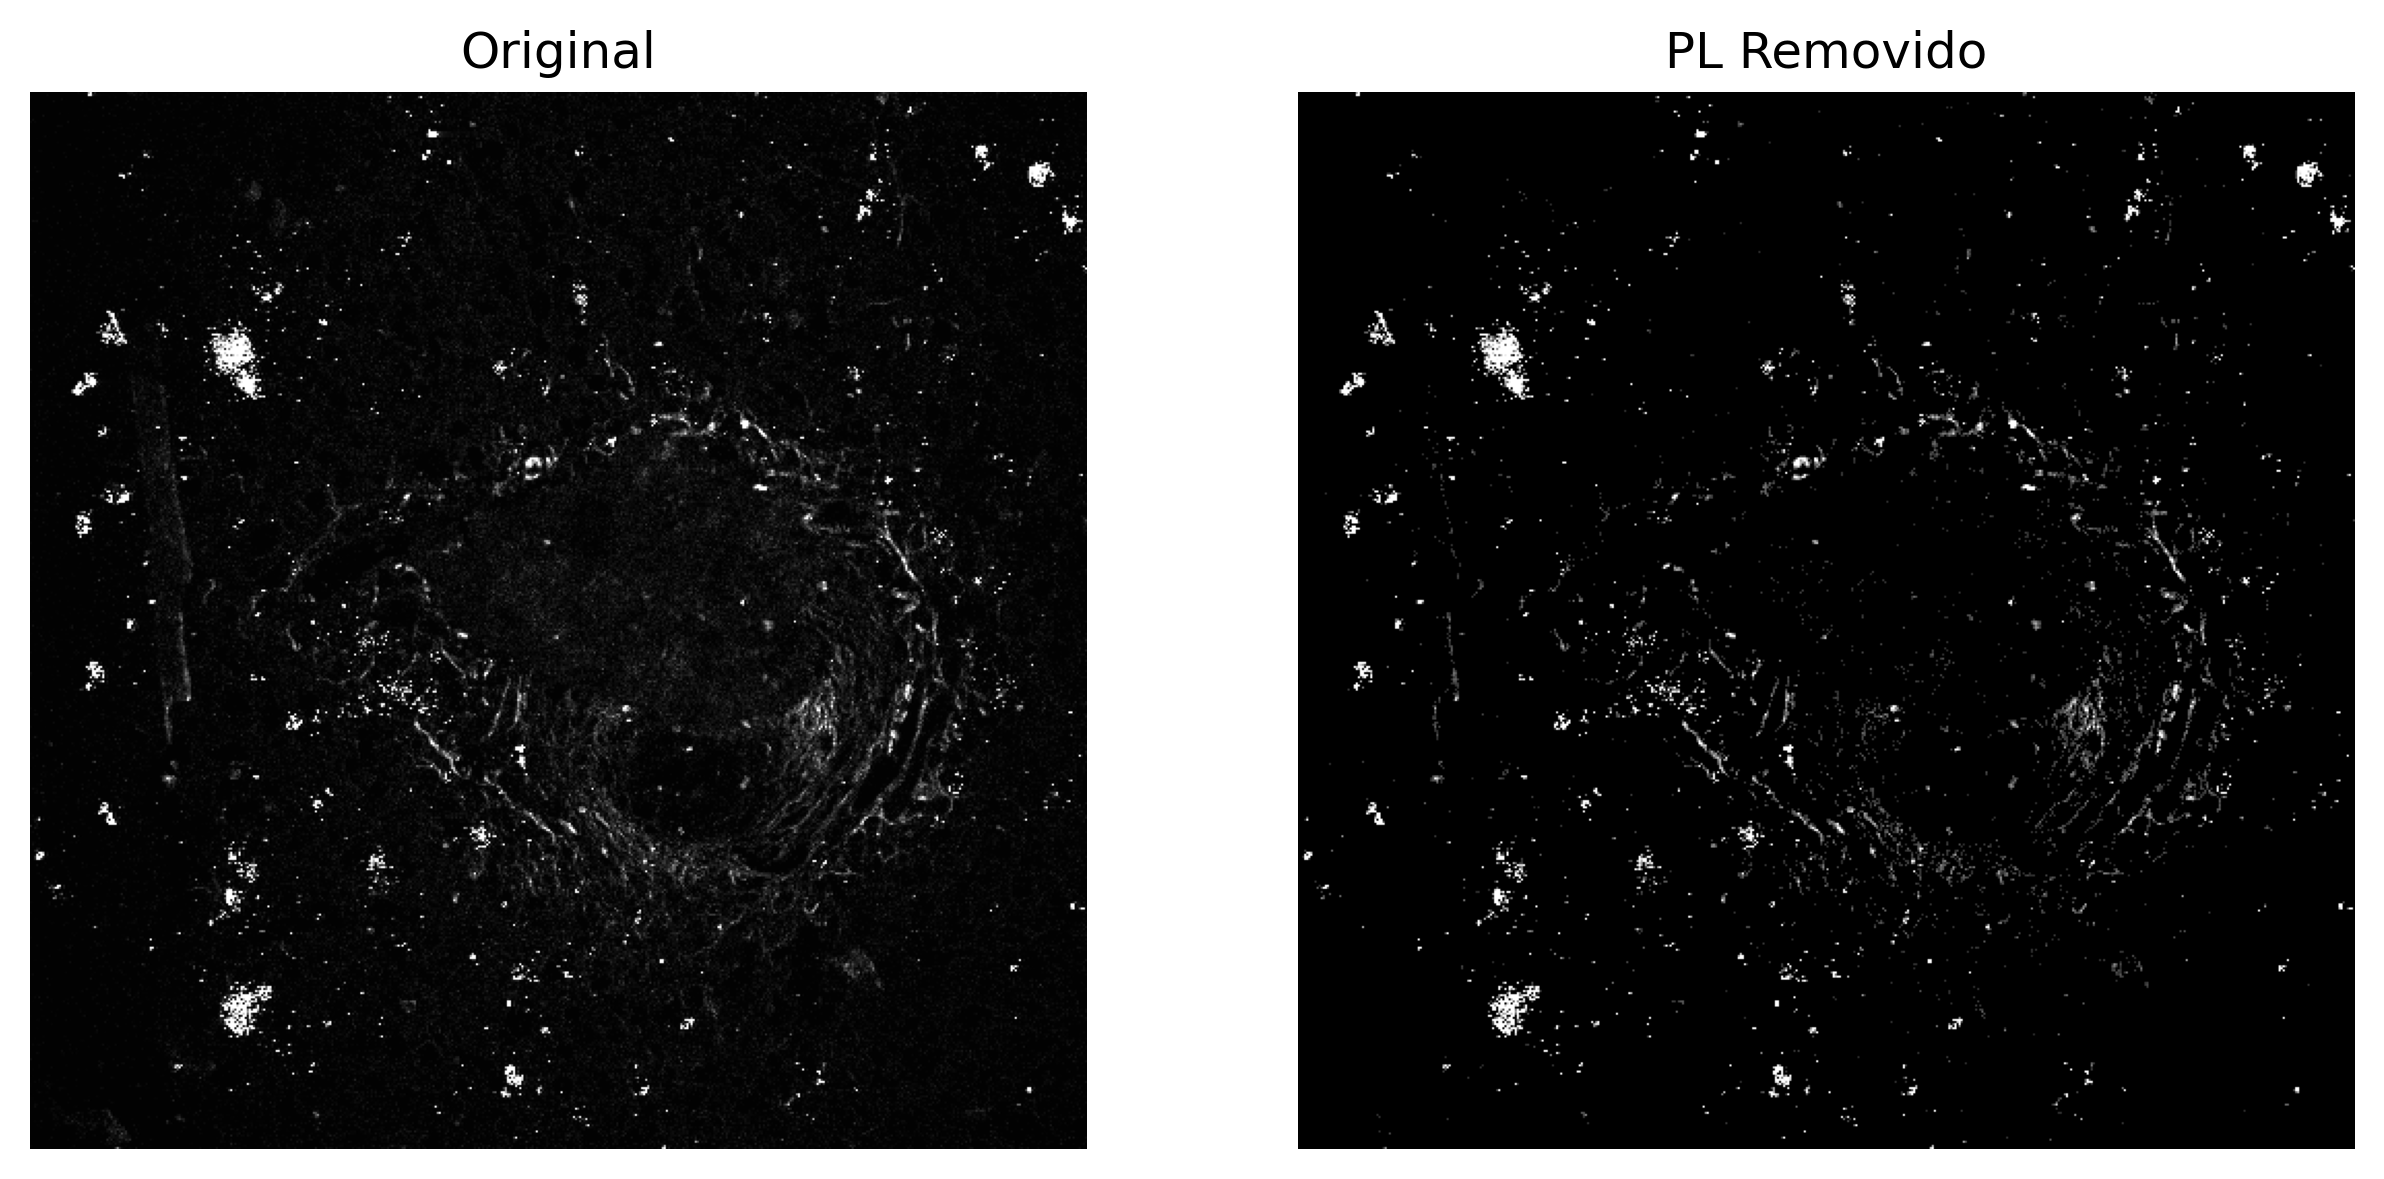

In [24]:
#Usando threshold do passa baixa como threshold global
#Usando valor máximo de intensidade do passa baixa como threshold
copy_image = image.copy()
max_intensity = parameters[0]
for row in copy_image:
  for i in range(len(row)):
    if row[i] <= max_intensity:
      row[i] = 0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=300)
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
#ax.hist(copy_image.ravel(), bins=255)
#ax.set_yscale('log')
ax[0].axis('off')
ax[1].imshow(copy_image, cmap='gray')
ax[1].set_title('PL Removido')
ax[1].axis('off')
plt.show()

In [17]:
#Estimando threshold filtro bassa baixa
threshold = threshold_multiotsu(blur, classes=2)
print(threshold)

[246]


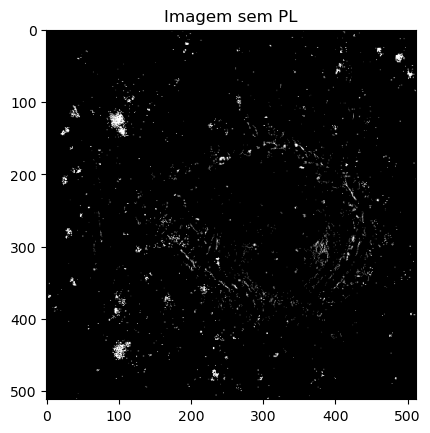

In [21]:
# Subtrai o fundo estimado
no_PL = cv2.subtract(image, blur)

def calculate_treshold_and_variance_between_classes(image):
  '''Calcula o threshold que maximiza a variância entre classes (método de Otsu),
     assim como a variância máxima, para duas classes somente'''
  intensity, count = np.unique(image, return_counts=True)

  n = len(intensity)

  probability = count/count.sum()

  cumulative_probability = probability.cumsum()

  E_i = intensity * probability

  partial_weighted_sum = E_i.cumsum()

  global_mean = E_i.sum()

  mean_C1 = np.zeros_like(intensity, dtype=float)

  cumulative_probability_C1 = np.zeros_like(intensity, dtype=float)

  mean_C0 = partial_weighted_sum/cumulative_probability

  mean_C1[:-1] = (partial_weighted_sum[-1] - partial_weighted_sum[:-1]) / (1 - cumulative_probability[:-1])

  cumulative_probability_C1[:-1] = 1 - cumulative_probability[:-1]

  variance_between_classes = cumulative_probability*(global_mean - mean_C0)**2+cumulative_probability_C1*(global_mean-mean_C1)**2

  indice_maior_valor = np.argmax(variance_between_classes)

  return intensity[indice_maior_valor], variance_between_classes[indice_maior_valor]

def interest_class(figure_to_aply, figure_to_calculate, fator_multiplicativo):
  threshold = calculate_treshold_and_variance_between_classes(figure_to_calculate)[0]
  SHG_class = figure_to_aply.copy()
  for row in SHG_class:
    for i in range(len(row)):
      if row[i] < threshold-500:
        row[i] = 11*fator_multiplicativo
  return SHG_class


plt.imshow(interest_class(image, no_PL,0), cmap='gray')
plt.title('Imagem sem PL')
plt.savefig('imagem.png')
plt.show()